(128, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 8, 9, 3)


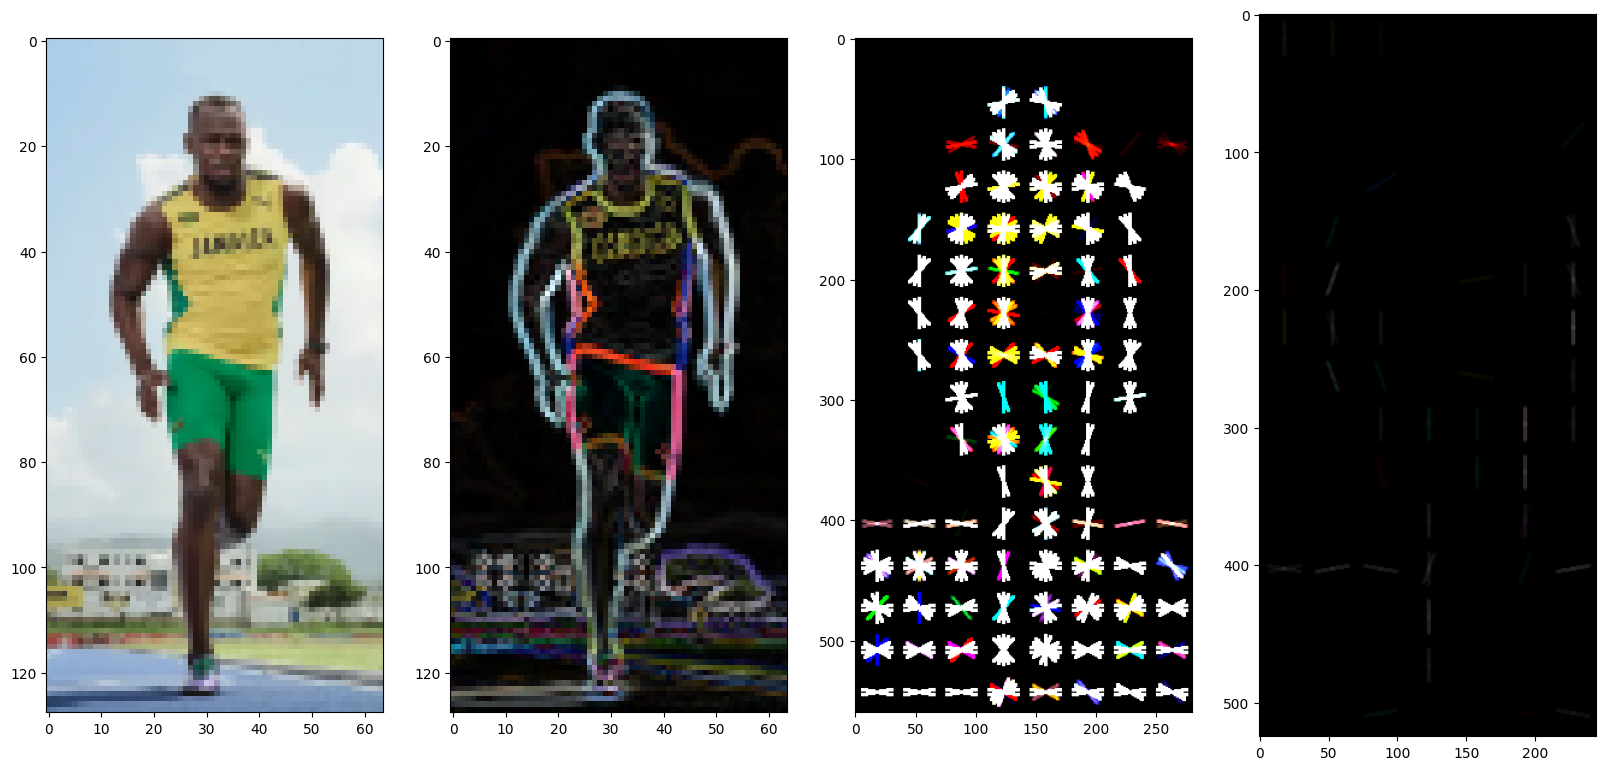

In [1]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
from HistogramOfGradients import HOG, Get_HOG_Graphics

img_path = os.path.join("test_images","bolt.png")
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print(img.shape)
nbins=9
hog = HOG(img,nbins=nbins)

#plt.imshow(hog.Get_Norm_HOG_Graphics())
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,14))
ax[0].imshow(hog.original_image)
ax[1].imshow(hog.gmag)
ax[2].imshow(Get_HOG_Graphics(hog.hogs, nbins, thick=2))
ax[3].imshow(Get_HOG_Graphics(hog.norm_hogs, nbins,thick=2))
plt.show()




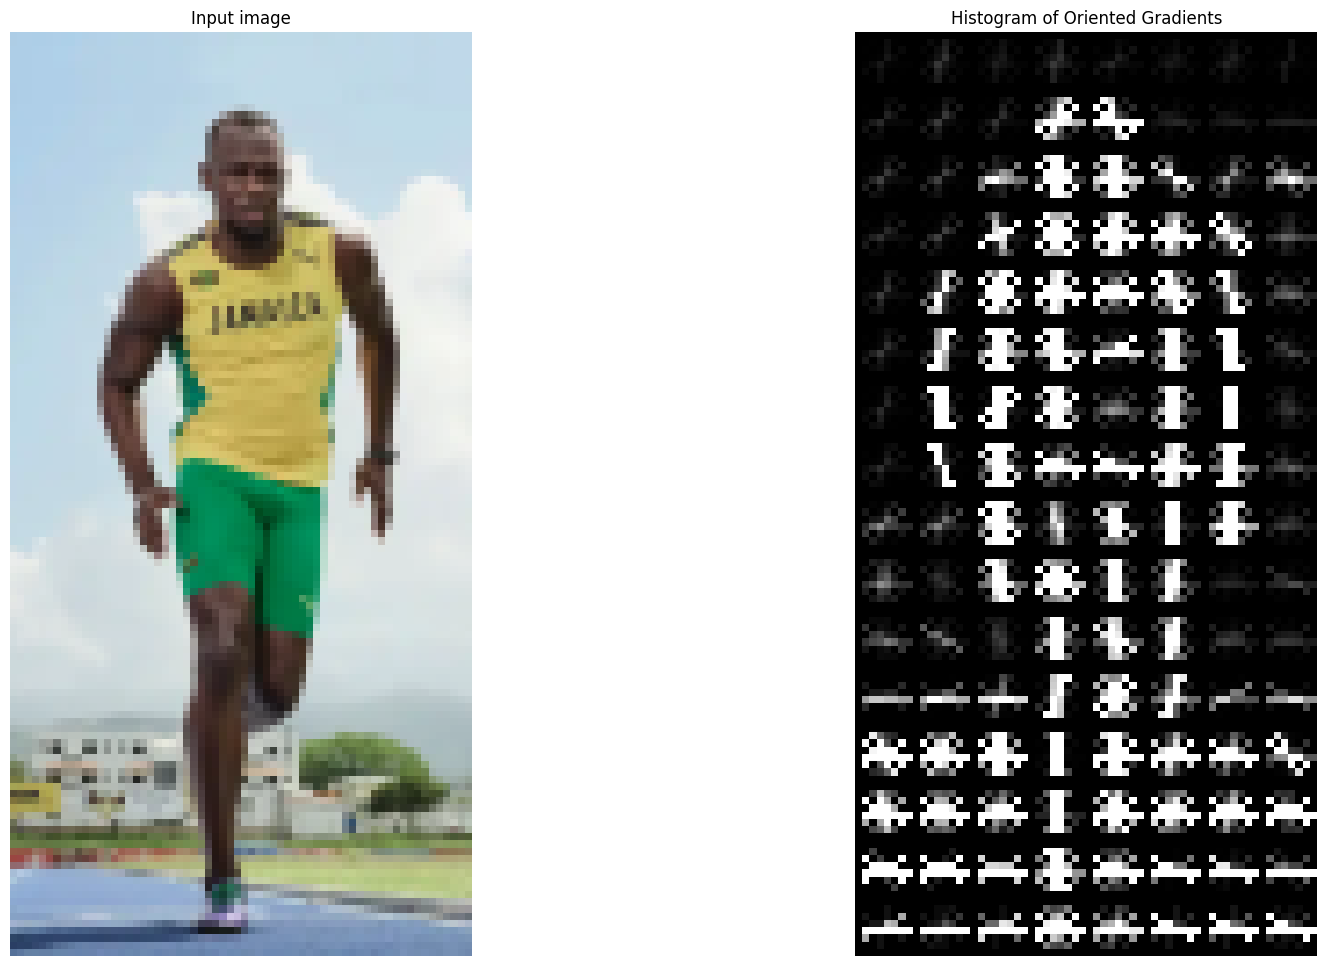

(128, 64, 3) (128, 64) (1152,) float64
[0.46337291 0.2928286  0.46337291 0.46337291 0.39287079 0.1464143
 0.09260053 0.2928286  0.         0.44791318 0.44791318 0.44791318
 0.19735753 0.23306175 0.25560352 0.10986636 0.44791318 0.1637791
 0.36881709 0.36881709 0.36881709 0.17854541 0.36881709 0.36881709
 0.36881709 0.36881709 0.12625067 0.38087856 0.14651363 0.38087856]


In [2]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure
from HistogramOfGradients import HOG


#image = data.astronaut()

img_path = os.path.join("test_images","bolt.png")
img = cv2.imread(img_path)
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(1,1), visualize=True, channel_axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()
print(image.shape, hog_image.shape, fd.shape, fd.dtype)
print(fd[:30])

(512, 512, 3)
torch.Size([1, 3, 512, 512]) torch.float32
torch.Size([1, 3, 128, 64])
(3, 128, 64)
(512,) 512


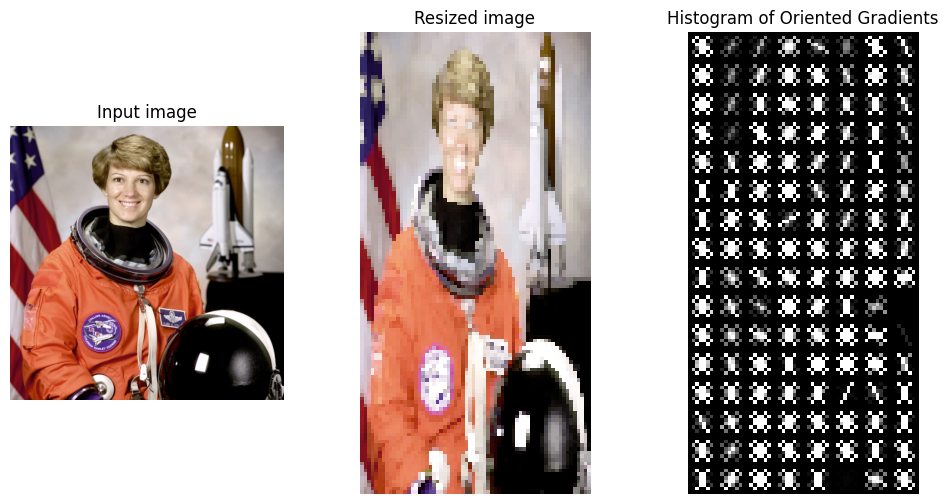

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage import data, exposure
import torch
from torchvision.ops import roi_pool

target_res=(128,64)

image = data.astronaut()
print(image.shape)
input_tensor = torch.from_numpy(image).permute(2,0,1).unsqueeze(0).to(torch.float)
print(input_tensor.shape, input_tensor.dtype)
boxes = torch.tensor((0,0,0,512,512)).reshape(1,5).to(torch.float)

img_pooled = roi_pool(input_tensor,boxes,target_res)
print(img_pooled.shape)
img_resized = img_pooled.reshape(3,128,64).to(torch.uint8).numpy()
print(img_resized.shape)


fd, hog_image = hog(img_resized, orientations=4, pixels_per_cell=(8, 8),
                    cells_per_block=(1,1), visualize=True, channel_axis=0)

print(fd.shape, fd.size)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 6))#, sharex=True, sharey=True)

ax0.axis('off')
ax0.imshow(image, cmap=plt.cm.gray)
ax0.set_title('Input image')

ax1.axis('off')
ax1.imshow(img_resized.transpose(1,2,0))
ax1.set_title('Resized image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

original: (256, 128, 3)


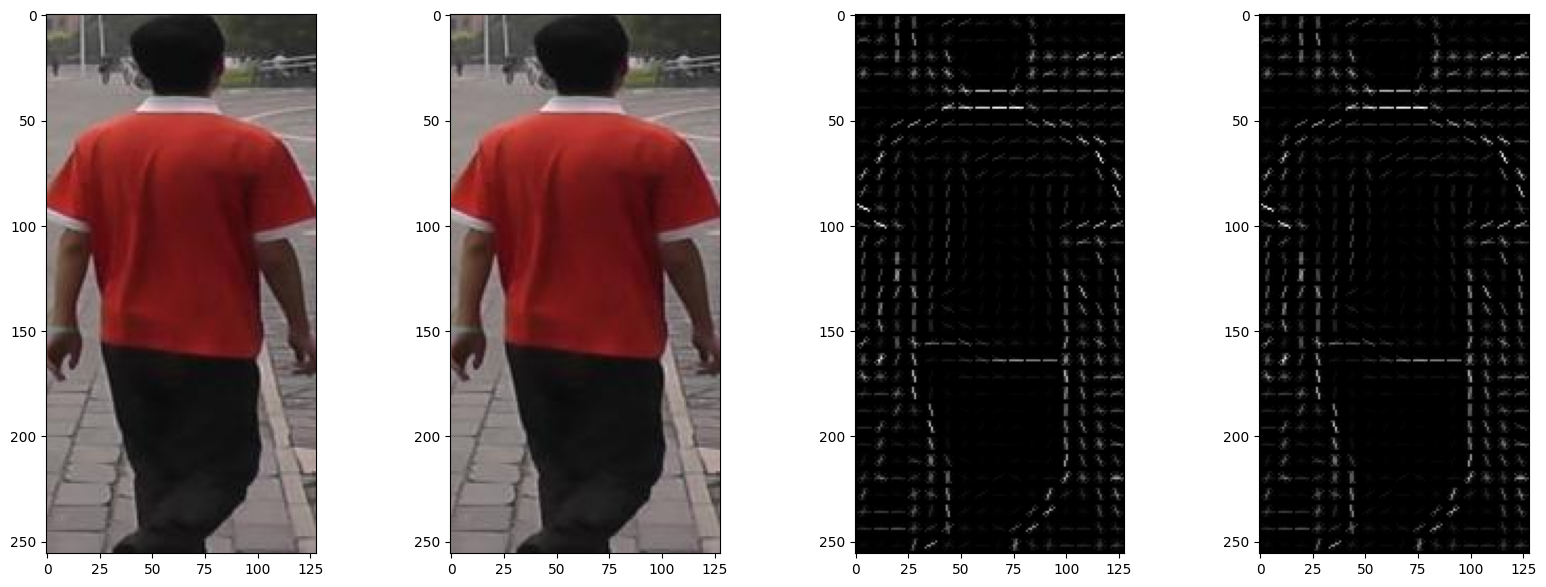

In [31]:
import torch
import torch.nn as nn
import time
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]='True'
from matplotlib import pyplot as plt
import sys
import random
import cv2
from torchvision.ops import roi_pool
import torchvision.transforms as T

from skimage.feature import hog
from skimage import data, exposure

from HistogramOfGradients import HOG, Get_HOG_Graphics, Normalize
from HogDescriber import HOGModel

img_path = os.path.join("test_images","ex_1.jpg")
#img_path = os.path.join("test_images","bolt.png")

original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

target_res=(256,128)
pixels_per_cell=8
rows = int(target_res[0]/pixels_per_cell)
cols = int(target_res[1]/pixels_per_cell)
nbins=9

transform = T.Compose([
        T.ToTensor(),
        T.Resize(target_res),
    ])

print("original:", original_img.shape)
scaled = transform(original_img).permute(1,2,0).numpy()
#print("scaled:", scaled.shape)
fd, fd_vis = hog(scaled, orientations=nbins, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                    cells_per_block=(1,1), visualize=True, channel_axis=2)
fd =fd.reshape(((rows, cols, nbins, -1)))
#print("fd-shape:", fd.shape)


img = torch.from_numpy(scaled).permute(2,1,0)
img = img.unsqueeze(0)

#print(img.shape)
model = HOGModel(nbins=nbins, pixels_per_cell=pixels_per_cell)

model.eval()
hog_img = model(img)
hog_img = hog_img.reshape((rows, cols, nbins, -1)).numpy()

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(fd_vis, in_range=(0, 10))


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,7))
ax[0].imshow(original_img)
ax[1].imshow(scaled)
ax[2].imshow(fd_vis, cmap=plt.cm.gray)

ax[3].imshow(hog_image_rescaled, cmap=plt.cm.gray)
#ax[4].imshow(Get_HOG_Graphics(norm_fd, nbins, thick=1, plot_dim=8), cmap=plt.cm.gray)

#ax[4].imshow(Get_HOG_Graphics(hog_img, nbins, thick=1, plot_dim=8))
#ax[5].imshow(Get_HOG_Graphics(norm_hogs, nbins, thick=1, plot_dim=8))
plt.show()
